In [7]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="sans-serif",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [8]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [9]:
df = pd.read_csv("train.csv")
df.columns = df.columns.str.replace(' ', '_').str.lower()

df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")


In [10]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [11]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

In [12]:
agg_df.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.00
33,2013-01-02,AUTOMOTIVE,255.00
66,2013-01-03,AUTOMOTIVE,161.00
99,2013-01-04,AUTOMOTIVE,169.00
132,2013-01-05,AUTOMOTIVE,342.00


In [13]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.00,0.00,2.00,810.00,0.00,180.59,0.00,186.00,143.00,71.09,46.00,29.65,700.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,5.00,105.00,0.00,110.80,25.00,0.00,0.00,42.64,37.85,0.00,0.00,0.00
2013-01-02,255.00,0.00,207.00,72092.00,0.00,26246.32,0.00,74629.00,23381.00,15754.50,10932.00,7115.39,202020.00,1476.00,46.00,0.00,0.00,21.00,0.00,0.00,121.00,469.00,2411.00,0.00,20871.46,17204.00,0.00,0.00,13975.88,5338.11,0.00,0.00,1526.75
2013-01-03,161.00,0.00,125.00,52105.00,0.00,18456.48,0.00,55893.00,18001.00,11172.45,7358.00,4760.81,144878.00,1048.00,37.00,0.00,0.00,15.00,0.00,0.00,83.00,366.00,2476.00,0.00,16597.40,12568.00,0.00,0.00,10674.39,3591.39,0.00,0.00,1094.31
2013-01-04,169.00,0.00,133.00,54167.00,0.00,16721.97,0.00,52064.00,18148.00,10143.21,6760.00,4525.93,135754.00,1031.00,57.00,0.00,0.00,13.00,0.00,0.00,127.00,382.00,4796.00,0.00,21625.96,11303.00,0.00,0.00,10772.52,4472.97,0.00,0.00,1293.12
2013-01-05,342.00,0.00,191.00,77818.00,0.00,22367.76,0.00,70128.00,23082.00,13734.95,8576.00,5781.61,188356.00,1273.00,87.00,0.00,0.00,11.00,0.00,0.00,180.00,458.00,6715.00,0.00,20879.09,16819.00,0.00,0.00,13475.01,5830.07,0.00,0.00,1245.64


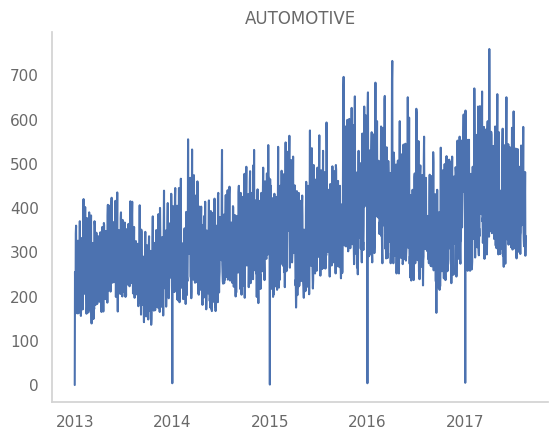

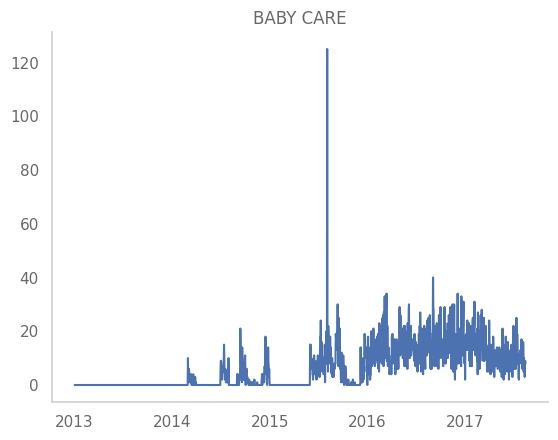

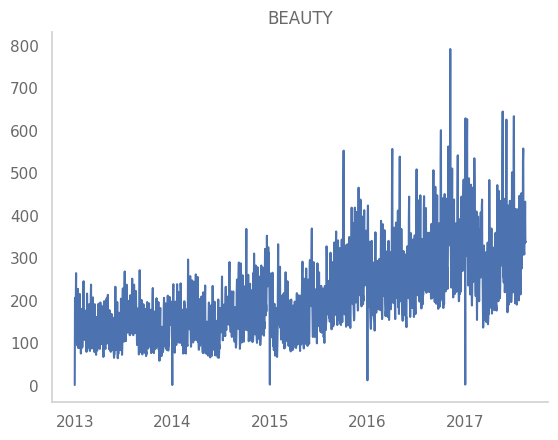

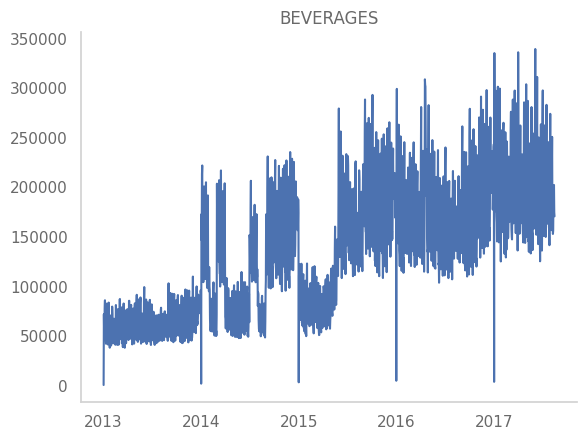

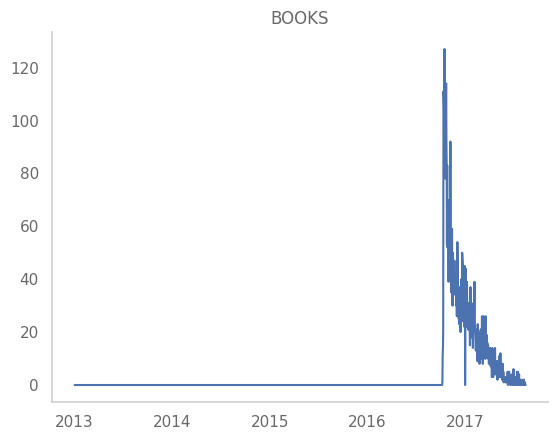

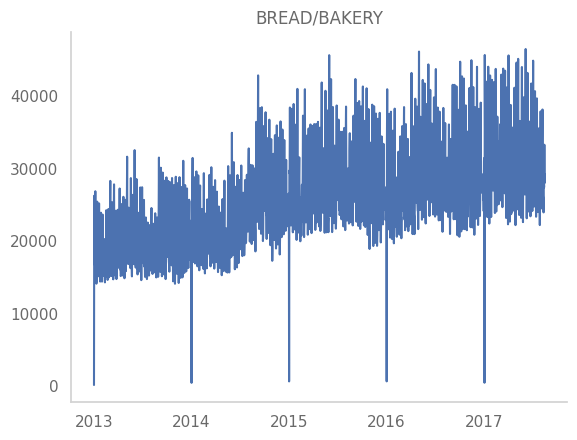

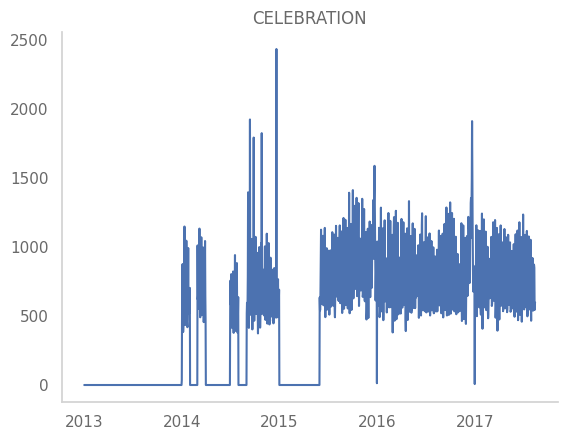

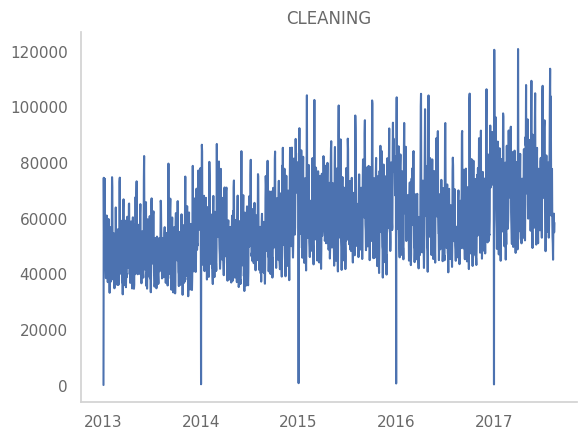

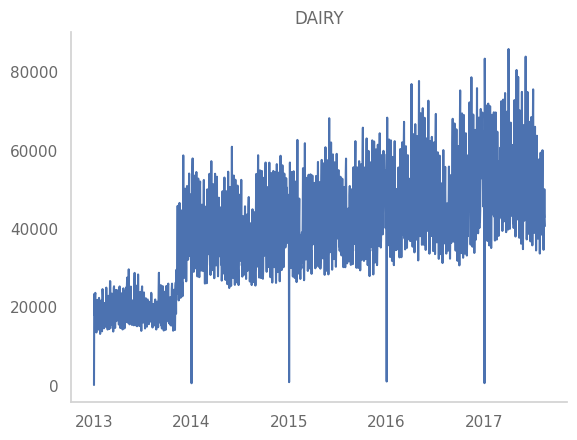

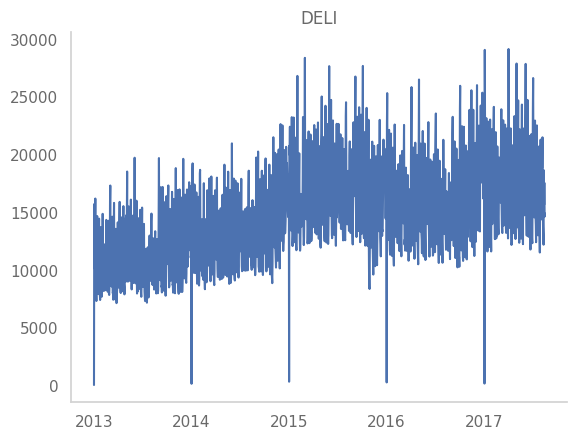

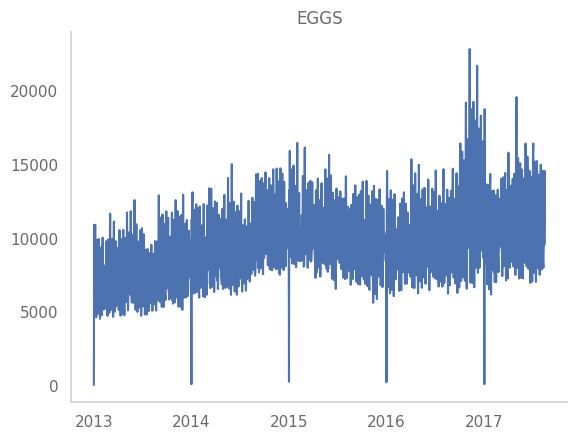

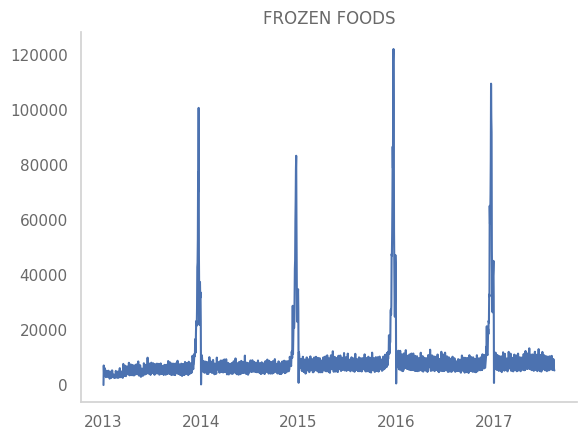

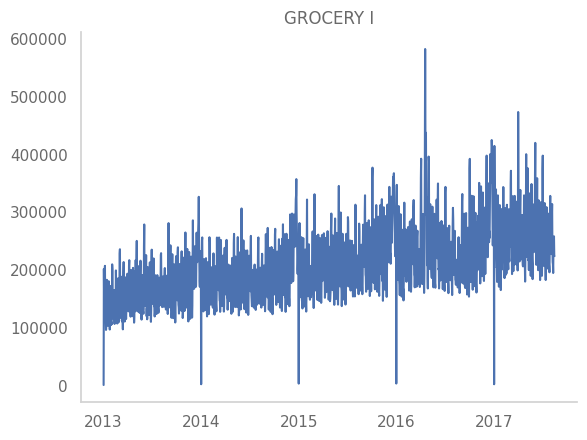

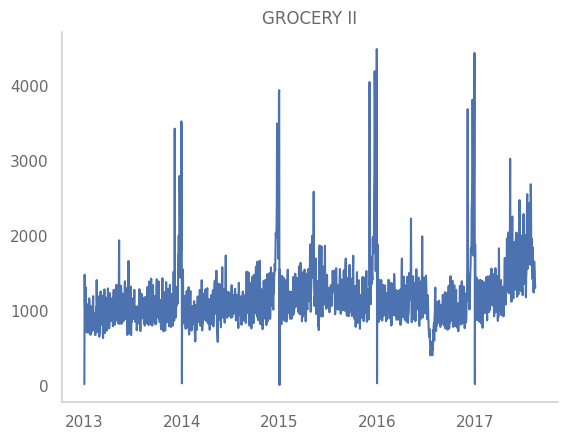

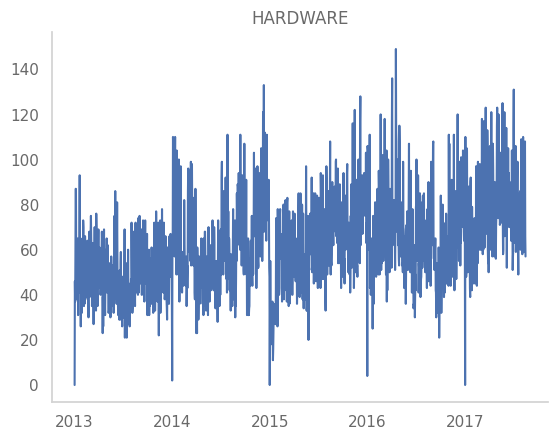

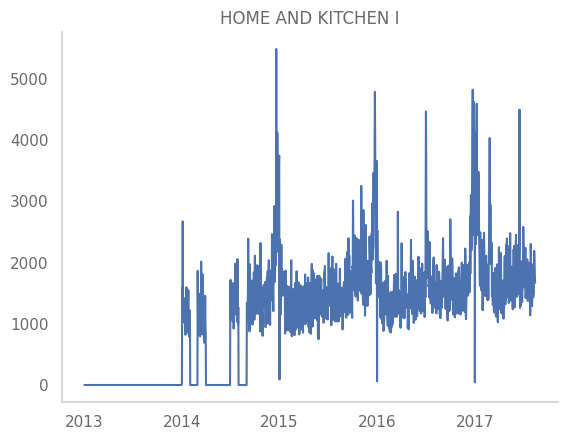

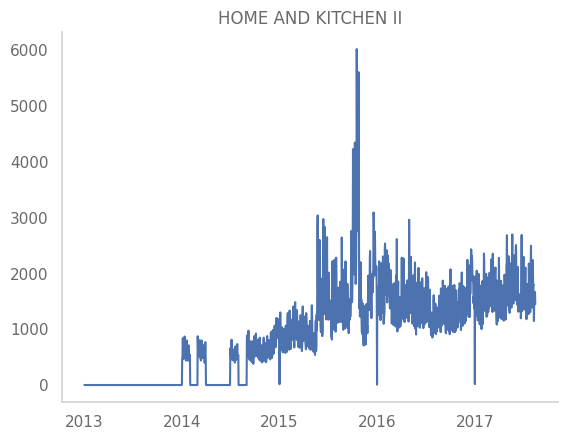

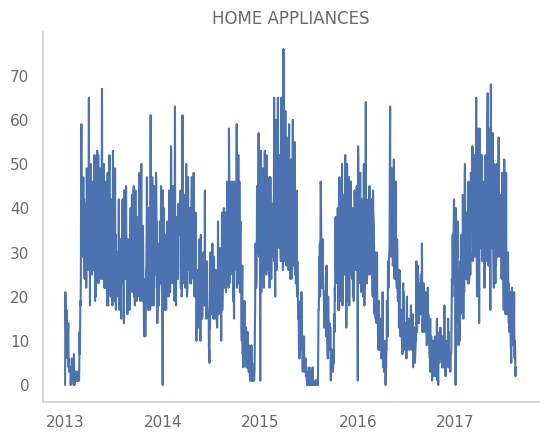

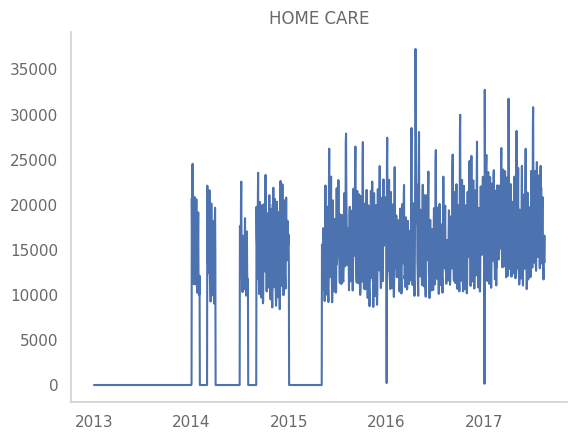

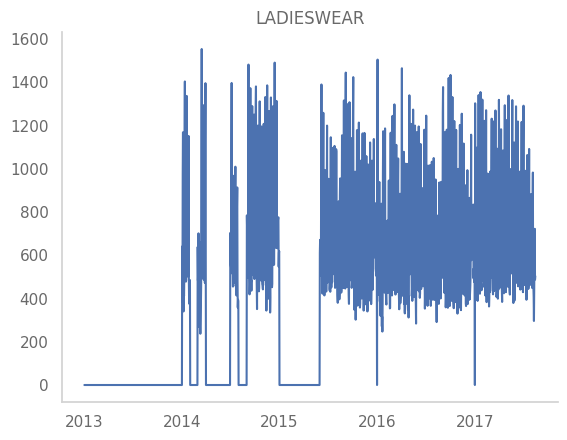

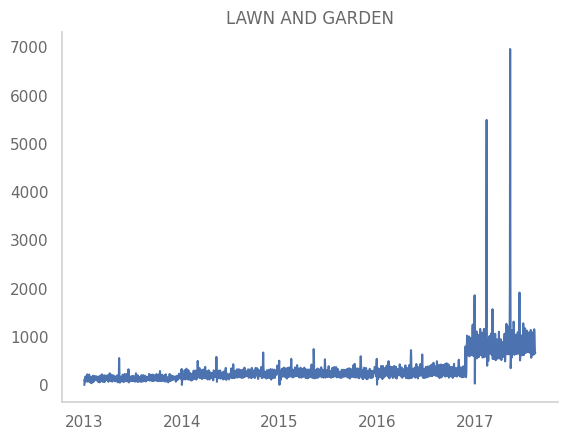

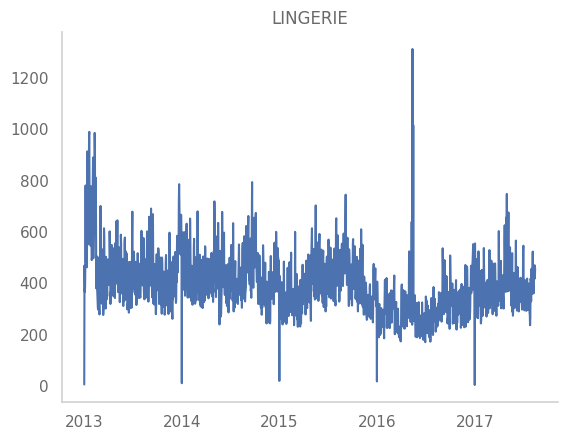

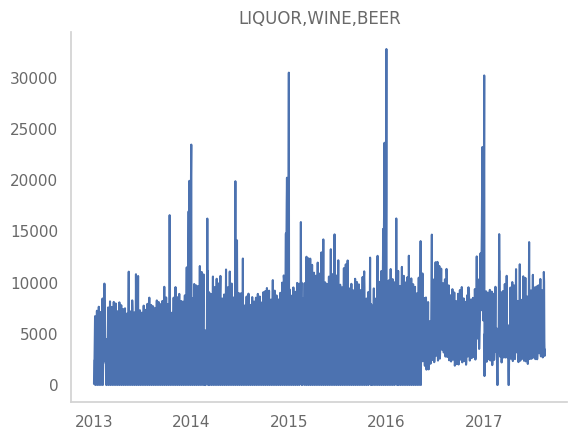

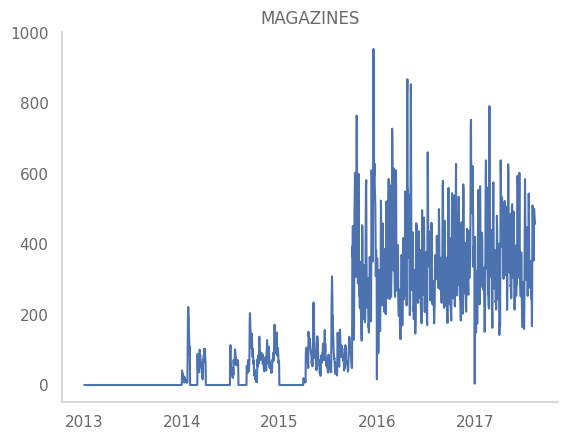

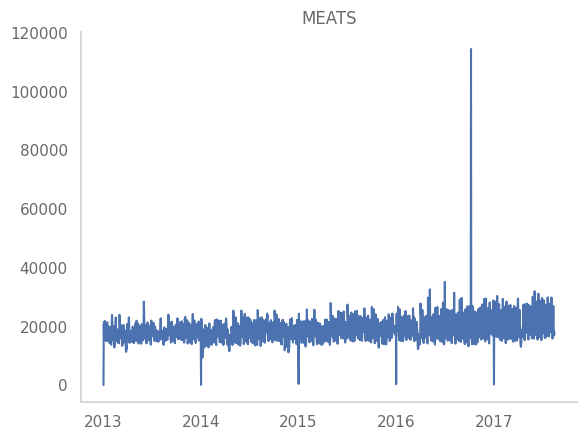

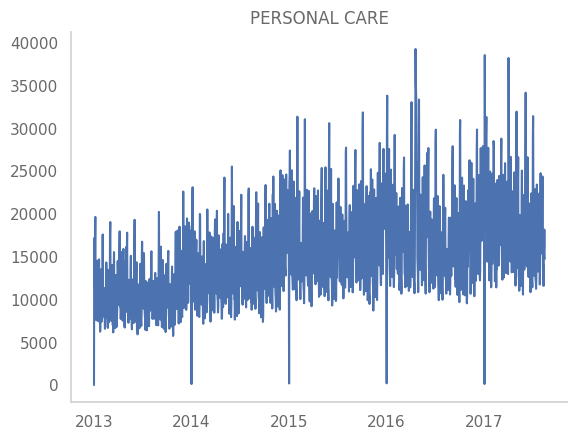

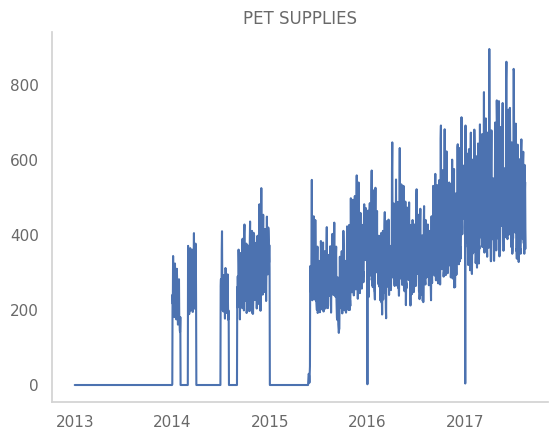

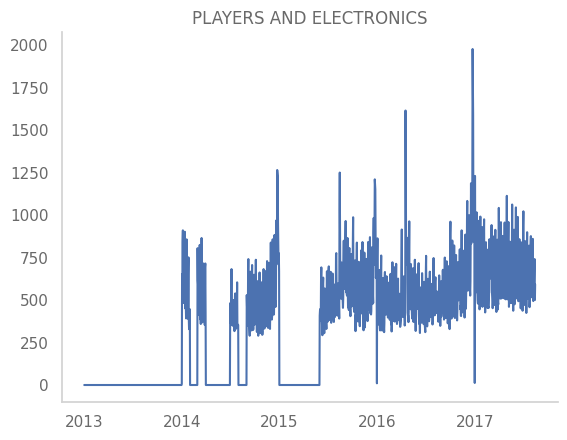

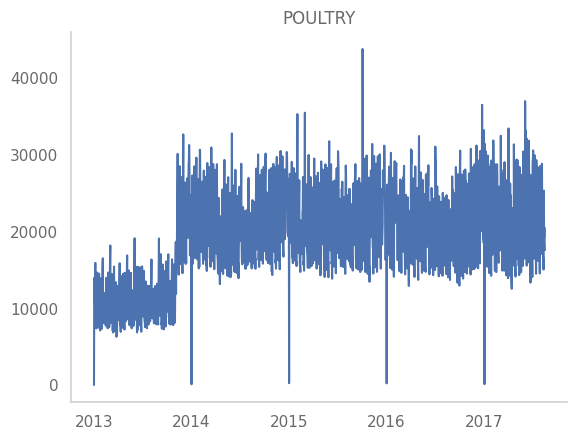

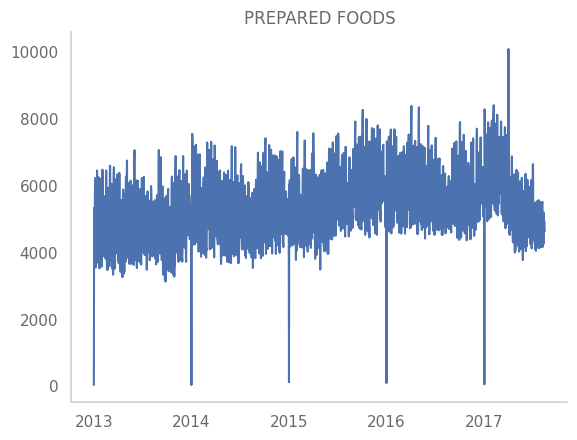

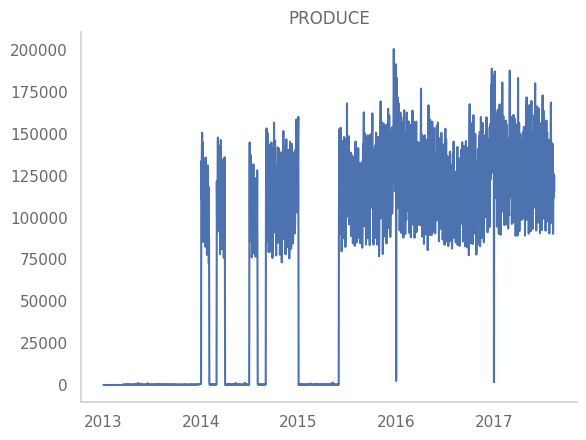

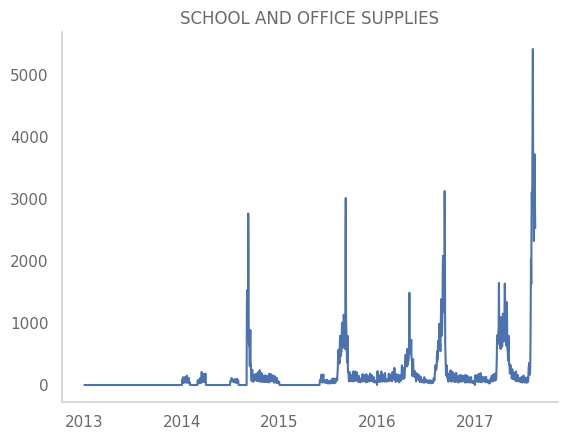

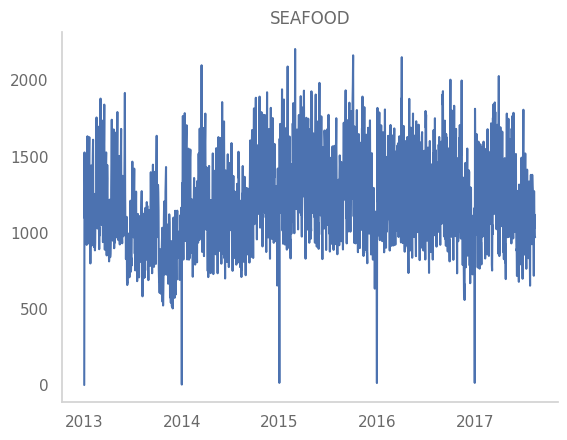

In [14]:
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

In [15]:
total_sales_df = total_sales_df[total_sales_df.index>='2015-08-15']

In [16]:
missing_data(total_sales_df)

,Total,Percent,Types
family,,,
AUTOMOTIVE,0,0.00,float64
BABY CARE,0,0.00,float64
BEAUTY,0,0.00,float64
BEVERAGES,0,0.00,float64
BOOKS,0,0.00,float64
BREAD/BAKERY,0,0.00,float64
CELEBRATION,0,0.00,float64
CLEANING,0,0.00,float64
DAIRY,0,0.00,float64


In [17]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [18]:
low_vol_columns = list(avg_daily_sales[avg_daily_sales<=low].index)
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

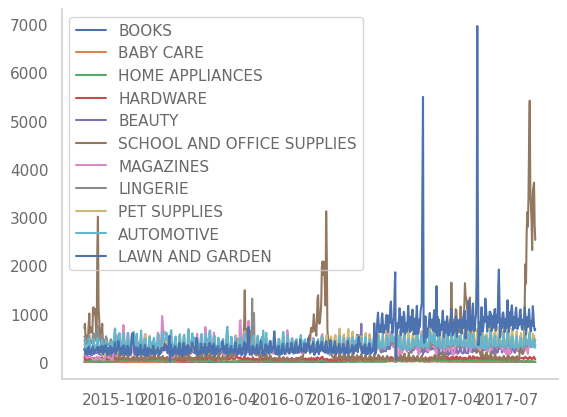

In [19]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.show()

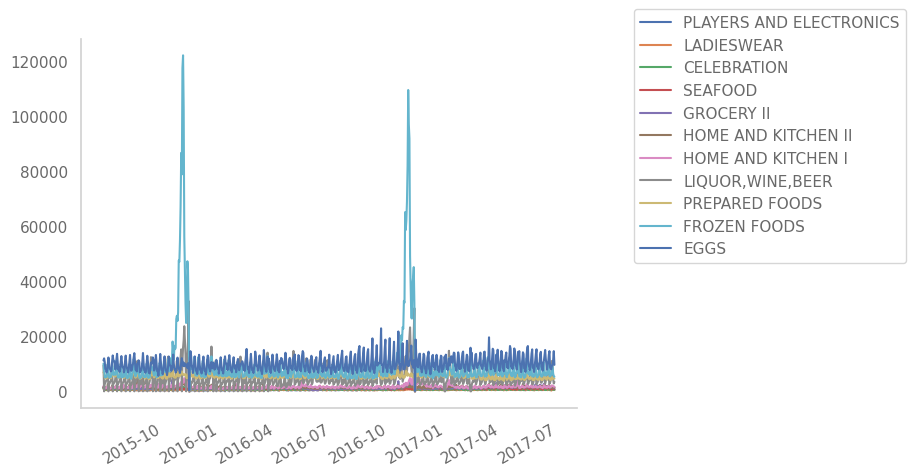

In [20]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

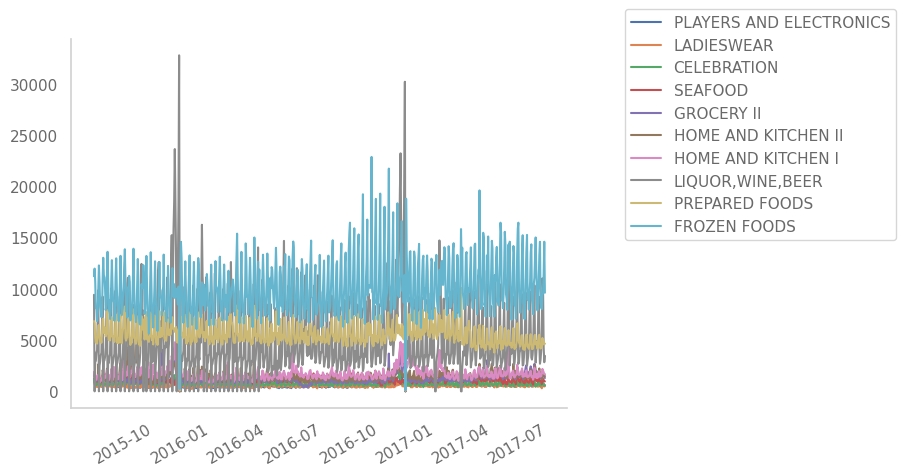

In [21]:
plt.plot(total_sales_df[mid_vol_columns].drop(columns='FROZEN FOODS'))
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

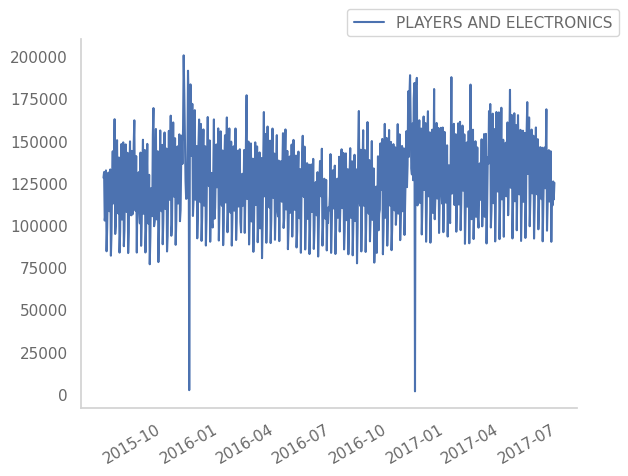

In [22]:
plt.plot(total_sales_df['PRODUCE'])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

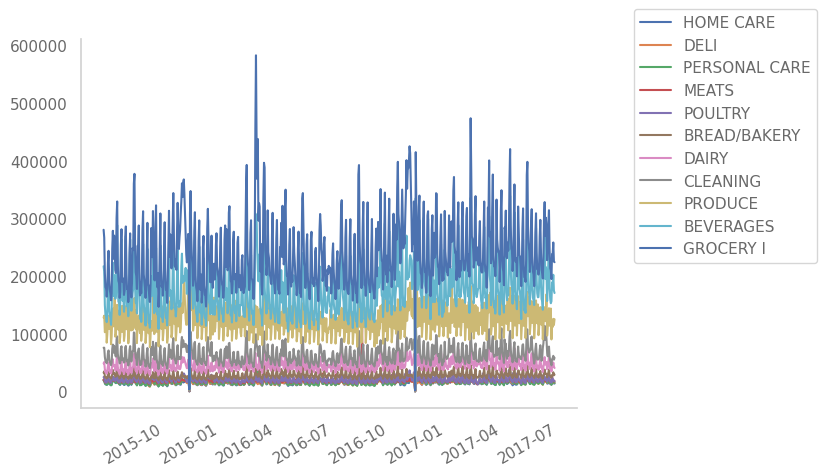

In [23]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

In [24]:
#setting variables
feature = 'PRODUCE'
prediction_days = 30

In [25]:
df = total_sales_df[[feature]].reset_index()
df.head()

family,date,PRODUCE
0,2015-08-15,128147.18
1,2015-08-16,131493.93
2,2015-08-17,102769.60
3,2015-08-18,106468.23
4,2015-08-19,132449.58


In [26]:
#adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

/tmp/ipykernel_103453/1667473210.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


,ds,holiday,lower_window,upper_window
0,2015-01-01,EC-Holidays,-2,1
1,2015-02-16,EC-Holidays,-2,1
2,2015-02-17,EC-Holidays,-2,1
3,2015-04-03,EC-Holidays,-2,1
4,2015-05-01,EC-Holidays,-2,1


In [27]:
#Variables

forecast_start_dt = date(2017,7,1) #data set ends of (2017,8,15)
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d") 
print(forecast_start_date)

2017-07-01


In [28]:
#PROPHET MODEL

df_copy = df.copy()
df_copy = df_copy.rename(columns={'date': 'ds', feature: 'y'})
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

df_copy['ds'] = pd.to_datetime(df_copy['ds'])

train_set = df_copy[(df_copy['ds'] < forecast_start_date) ]

m = Prophet()

m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

13:27:26 - cmdstanpy - INFO - Chain [1] start processing
13:27:26 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
predicted_df.head(10)

,ds,yhat
684,2017-07-01,144551.55
685,2017-07-02,155275.79
686,2017-07-03,122322.49
687,2017-07-04,127581.74
688,2017-07-05,160193.66
689,2017-07-06,102606.63
690,2017-07-07,115957.70
691,2017-07-08,144801.94
692,2017-07-09,155526.18
693,2017-07-10,122572.87


In [30]:
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)

In [31]:
predicted_df

,ds,yhat,ytrue
0,2017-07-01,144551.55,155487.63
1,2017-07-02,155275.79,172890.14
2,2017-07-03,122322.49,130389.20
3,2017-07-04,127581.74,131534.55
4,2017-07-05,160193.66,163804.33
5,2017-07-06,102606.63,99395.60
6,2017-07-07,115957.70,114346.57
7,2017-07-08,144801.94,139294.77
8,2017-07-09,155526.18,156633.92
9,2017-07-10,122572.87,118856.99


In [32]:
mape(predicted_df['ytrue'], predicted_df['yhat'])

np.float64(6.232212641805213)

In [33]:
m = Prophet()
m.fit(train_set)
df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days')

13:27:26 - cmdstanpy - INFO - Chain [1] start processing
13:27:26 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/10 [00:00<?, ?it/s]13:27:26 - cmdstanpy - INFO - Chain [1] start processing
13:27:26 - cmdstanpy - INFO - Chain [1] done processing
13:27:26 - cmdstanpy - INFO - Chain [1] start processing
13:27:26 - cmdstanpy - INFO - Chain [1] done processing
13:27:26 - cmdstanpy - INFO - Chain [1] start processing
13:27:26 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 3/10 [00:00<00:00, 21.77it/s]13:27:26 - cmdstanpy - INFO - Chain [1] start processing
13:27:26 - cmdstanpy - INFO - Chain [1] done processing
13:27:26 - cmdstanpy - INFO - Chain [1] start processing
13:27:26 - cmdstanpy - INFO - Chain [1] done processing
13:27:26 - cmdstanpy - INFO - Chain [1] start processing
13:27:26 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 6/10 [00:00<00:00, 20.01it/s]13:27:26 - cmdstanpy - INFO - Chain [1] start processing
13:27:26 - cmdstanpy -

In [34]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,409760751.07,20242.55,13048.48,0.09,0.07,0.10,0.80
1,4 days,268340338.98,16381.10,11099.49,0.08,0.06,0.08,0.80
2,5 days,140946716.48,11872.10,8898.09,0.07,0.06,0.07,0.87
3,6 days,125646472.80,11209.21,9213.13,0.07,0.07,0.07,0.87
4,7 days,95432475.73,9768.95,8406.53,0.07,0.07,0.07,0.93
5,8 days,75869850.32,8710.33,7690.14,0.06,0.07,0.06,0.97
6,9 days,61456214.50,7839.40,6612.24,0.06,0.05,0.05,0.97
7,10 days,49474415.32,7033.81,5433.12,0.05,0.04,0.05,0.97
8,11 days,78803127.28,8877.11,6728.51,0.05,0.04,0.05,0.93
9,12 days,83074092.96,9114.50,6711.97,0.05,0.05,0.05,0.93


In [35]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,409760751.07,20242.55,13048.48,0.09,0.07,0.10,0.80
1,4 days,268340338.98,16381.10,11099.49,0.08,0.06,0.08,0.80
2,5 days,140946716.48,11872.10,8898.09,0.07,0.06,0.07,0.87
3,6 days,125646472.80,11209.21,9213.13,0.07,0.07,0.07,0.87
4,7 days,95432475.73,9768.95,8406.53,0.07,0.07,0.07,0.93


In [36]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
23,26 days,255321339.99,15978.78,12051.51,0.10,0.08,0.10,0.83
24,27 days,305998718.10,17492.82,13271.14,0.11,0.09,0.11,0.80
25,28 days,503579310.92,22440.57,15736.36,0.13,0.09,0.13,0.77
26,29 days,550773207.50,23468.56,16646.15,0.12,0.09,0.13,0.66
27,30 days,1247655619.21,35322.17,21528.35,3.01,0.12,0.19,0.63


In [37]:
df_cv['mape'] = (df_cv['y']-df_cv['yhat'])/(df_cv['y'])*100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y'] 

df_cv.sort_values('mape',ascending=False).head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
110,2016-12-23,98378.94,82289.40,113774.35,176327.97,2016-12-02,44.21,False
116,2016-12-30,98423.75,83048.87,115029.68,175022.19,2016-12-02,43.76,False
109,2016-12-22,87908.58,72881.07,103620.84,140444.94,2016-12-02,37.41,False
119,2017-01-02,117234.40,98335.27,136519.10,184113.03,2017-01-01,36.32,False
120,2017-01-03,121496.34,102066.32,140233.62,183306.23,2017-01-01,33.72,False
111,2016-12-24,127783.29,112359.74,143190.21,188809.16,2016-12-02,32.32,False
117,2016-12-31,127828.10,113379.99,143799.98,184154.67,2016-12-02,30.59,False
115,2016-12-29,87953.39,72659.89,102844.52,126652.84,2016-12-02,30.56,False
238,2017-05-01,126144.56,106773.48,145392.14,167558.58,2017-04-01,24.72,False
108,2016-12-21,143692.24,127952.84,159396.67,179251.71,2016-12-02,19.84,False


In [38]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
0,2016-09-04,137036.86,119897.08,153339.75,144954.39,2016-09-03,5.46,False
1,2016-09-05,103686.89,85603.60,119203.59,110104.68,2016-09-03,5.83,False
2,2016-09-06,107779.92,90972.48,123927.90,115898.16,2016-09-03,7.00,False
3,2016-09-07,140060.58,124028.36,155595.81,142809.15,2016-09-03,1.92,False
4,2016-09-08,84270.07,66710.61,100336.38,85680.68,2016-09-03,1.65,False
5,2016-09-09,93691.81,77581.35,109590.77,96152.02,2016-09-03,2.56,False
6,2016-09-10,123836.21,106446.37,139832.27,128750.47,2016-09-03,3.82,False
7,2016-09-11,136585.22,120172.28,153225.54,142536.23,2016-09-03,4.18,False
8,2016-09-12,103235.24,86980.44,119920.84,102988.54,2016-09-03,-0.24,True
9,2016-09-13,107328.27,91000.91,124062.12,104210.54,2016-09-03,-2.99,True


In [39]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] 

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_set)  # Fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

13:27:26 - cmdstanpy - INFO - Chain [1] start processing
13:27:26 - cmdstanpy - INFO - Chain [1] done processing
13:27:27 - cmdstanpy - INFO - Chain [1] start processing
13:27:27 - cmdstanpy - INFO - Chain [1] start processing
13:27:27 - cmdstanpy - INFO - Chain [1] start processing
13:27:27 - cmdstanpy - INFO - Chain [1] done processing
13:27:27 - cmdstanpy - INFO - Chain [1] done processing
13:27:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:27:27 - cmdstanpy - INFO - Chain [1] start processing
13:27:27 - cmdstanpy - INFO - Chain [1] start processing
13:27:27 - cmdstanpy - INFO - Chain [1] start processing
13:27:27 - cmdstanpy - INFO - Chain [1] start processing
13:27:27 - cmdstanpy - INFO - Chain [1] done processing
13:27:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
13:27:27 - cmdstanpy - INFO - Chain [1] start processing
13:27:27 - 

In [40]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale     rmse
0                      0.00                     0.01 18782.74
1                      0.00                     0.10 18893.21
2                      0.00                     1.00 18561.88
3                      0.00                    10.00 18653.47
4                      0.01                     0.01 18217.35
5                      0.01                     0.10 17783.71
6                      0.01                     1.00 17769.71
7                      0.01                    10.00 17707.99
8                      0.10                     0.01 18075.77
9                      0.10                     0.10 17730.75
10                     0.10                     1.00 17712.69
11                     0.10                    10.00 17700.07
12                     0.50                     0.01 18060.05
13                     0.50                     0.10 17756.85
14                     0.50                     1.00 17754.68
15      

In [41]:
tuning_results.sort_values('rmse')

,changepoint_prior_scale,seasonality_prior_scale,rmse
11,0.10,10.00,17700.07
7,0.01,10.00,17707.99
10,0.10,1.00,17712.69
9,0.10,0.10,17730.75
14,0.50,1.00,17754.68
13,0.50,0.10,17756.85
6,0.01,1.00,17769.71
15,0.50,10.00,17782.35
5,0.01,0.10,17783.71
12,0.50,0.01,18060.05


In [42]:
tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0]

changepoint_prior_scale       0.10
seasonality_prior_scale      10.00
rmse                      17700.07
Name: 0, dtype: float64

In [43]:
dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0])

{'changepoint_prior_scale': np.float64(0.1),
 'seasonality_prior_scale': np.float64(10.0),
 'rmse': np.float64(17700.071817885597)}

In [44]:
params_dictionary = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse',axis='columns').iloc[0])

m = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'], 
            seasonality_prior_scale = params_dictionary['seasonality_prior_scale'])


In [45]:
m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
mape(predicted_df['ytrue'], predicted_df['yhat'])

13:27:37 - cmdstanpy - INFO - Chain [1] start processing
13:27:37 - cmdstanpy - INFO - Chain [1] done processing


np.float64(4.789708629824525)

In [46]:
old_len = len(total_sales_df.columns)

#Keep categories with avg daily sales greater than $1000
total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.apply(np.mean,axis='rows') > 1000]]

print("Dropping "+ str(old_len-len(total_sales_df.columns))+" columns due to insufficient data volume.")

Dropping 14 columns due to insufficient data volume.


In [47]:
#Get percentage of rows for each category that is at 0

(total_sales_df == 0).astype(int).sum(axis=0)/len(total_sales_df.sum(axis=0))

family
BEVERAGES             0.00
BREAD/BAKERY          0.00
CLEANING              0.00
DAIRY                 0.00
DELI                  0.00
EGGS                  0.00
FROZEN FOODS          0.00
GROCERY I             0.00
GROCERY II            0.00
HOME AND KITCHEN I    0.00
HOME AND KITCHEN II   0.00
HOME CARE             0.00
LIQUOR,WINE,BEER      2.21
MEATS                 0.00
PERSONAL CARE         0.00
POULTRY               0.00
PREPARED FOODS        0.00
PRODUCE               0.00
SEAFOOD               0.00
dtype: float64

In [48]:
print(total_sales_df.columns)

Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'HOME CARE', 'LIQUOR,WINE,BEER', 'MEATS',
       'PERSONAL CARE', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SEAFOOD'],
      dtype='object', name='family')


In [49]:
#Need to break out each into it's own dataframe for prediction since each will have different rows affected
prediction_df_list = []

#Cleaning up dataframe using z-score to remove outliers which heavily bias the model
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 2.7)[0] #As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index=outlier_index,inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_df_list.append(df_clean)

Dropping 7 rows for following category: BEVERAGES
Dropping 11 rows for following category: BREAD/BAKERY
Dropping 10 rows for following category: CLEANING
Dropping 10 rows for following category: DAIRY
Dropping 9 rows for following category: DELI
Dropping 12 rows for following category: EGGS
Dropping 22 rows for following category: FROZEN FOODS
Dropping 11 rows for following category: GROCERY I
Dropping 15 rows for following category: GROCERY II
Dropping 23 rows for following category: HOME AND KITCHEN I
Dropping 15 rows for following category: HOME AND KITCHEN II
Dropping 13 rows for following category: HOME CARE
Dropping 11 rows for following category: LIQUOR,WINE,BEER
Dropping 4 rows for following category: MEATS
Dropping 14 rows for following category: PERSONAL CARE
Dropping 5 rows for following category: POULTRY
Dropping 3 rows for following category: PREPARED FOODS
Dropping 4 rows for following category: PRODUCE
Dropping 4 rows for following category: SEAFOOD
